In [1]:
import random
from pathlib import Path
from math import sqrt, pi

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
## Load in all csv result files & combine them to one pandas table
wells = ['D' + '{0:02d}'.format(x) for x in range(2,6)] + \
        ['E' + '{0:02d}'.format(x) for x in range(2,6)]

base_path_features = '/Users/Joel/shares/workShareJoel/20190725-StainingTest3/feature_values_laminB1_SVMs/20190723-StainingTest3_p1_'
base_path_metadata = '/Users/Joel/shares/workShareJoel/20190725-StainingTest3/feature_values_laminB1_SVMs/20190723-StainingTest3_p1_'
base_path_popcon = '/Users/Joel/shares/workShareJoel/20190725-StainingTest3/feature_values_laminB1/20190723-StainingTest3_p1_'
base_path_edge = '/Users/Joel/shares/workShareJoel/20190725-StainingTest3/feature_values_laminB1/20190723-StainingTest3_p1_'

results = pd.DataFrame()

for well in wells:
    curr_features = pd.read_csv(base_path_features + well + '_ExpandedNuclei-gfp_feature-values.csv')
    curr_metadata = pd.read_csv(base_path_metadata + well + '_ExpandedNuclei-gfp_metadata.csv')
    curr_popcon = pd.read_csv(base_path_popcon + well + '_ExpandedNuclei-gfp_popcon.csv')
    curr_edge = pd.read_csv(base_path_edge + well + '_ExpandedNuclei-gfp_edge.csv')
    curr_well_tmp = curr_features.merge(curr_metadata, on = ['mapobject_id'])
#     results = pd.concat([results, curr_well_tmp])
    curr_well2 = curr_well_tmp.merge(curr_popcon, on = ['mapobject_id'])
    curr_well = curr_well2.merge(curr_edge, on = ['mapobject_id'])
    results = pd.concat([results, curr_well])

# print(results.head())
print(results.columns.values)


['mapobject_id' 'Morphology_Local_Centroid_x'
 'Morphology_Local_Centroid_y' 'Morphology_Area' 'Morphology_Perimeter'
 'Morphology_Eccentricity' 'Morphology_Extent' 'Morphology_Convexity'
 'Morphology_Circularity' 'Morphology_Roundness' 'Morphology_Elongation'
 'Morphology_Equivalent_Diameter' 'Morphology_Major_Axis_Length'
 'Morphology_Minor_Axis_Length' 'Morphology_Maximum_Radius'
 'Morphology_Mean_Radius' 'Intensity_max_dapi.rescaled_image'
 'Intensity_mean_dapi.rescaled_image' 'Intensity_min_dapi.rescaled_image'
 'Intensity_sum_dapi.rescaled_image' 'Intensity_std_dapi.rescaled_image'
 'Intensity_max_gfp.rescaled_image' 'Intensity_mean_gfp.rescaled_image'
 'Intensity_min_gfp.rescaled_image' 'Intensity_sum_gfp.rescaled_image'
 'Intensity_std_gfp.rescaled_image' 'Intensity_max_568.rescaled_image'
 'Intensity_mean_568.rescaled_image' 'Intensity_min_568.rescaled_image'
 'Intensity_sum_568.rescaled_image' 'Intensity_std_568.rescaled_image'
 'Intensity_max_647.rescaled_image' 'Intensity_m

In [37]:
# # print(results.head())
# non_touching = sum(results['Neighbours_Fraction_Touching'] < 1)
# touching = sum(results['Neighbours_Fraction_Touching'] == 1)
# print(non_touching)
# print(non_touching / (non_touching + touching))

In [36]:
# fig1, ax1 = plt.subplots(2, 1, figsize=(15, 20))
# fig1.suptitle('Neighborhood Measurements', fontsize = 20)
# sns.violinplot(x = 'well_name', y = 'Neighbours_Neighbours_Count', data = results, ax=ax1[0])
# sns.violinplot(x = 'well_name', y = 'Neighbours_Fraction_Touching', data = results, ax=ax1[1])

In [4]:
sum_intensity_dapi = 'Intensity_sum_dapi.rescaled_image'
sum_Intensity_568 = 'Intensity_sum_568.rescaled_image'
# Filter out cells that are thrown out by SVM
correct_segment = (results['MitoticAndMissegmentation'] == 0)
non_border_cells = (results['is_border'] == 0)

# Filter out cells that have very low DAPI signal. Mostly missegmented HEK cells
normal_dapi = (results[sum_intensity_dapi] < 4500000) & (results[sum_intensity_dapi] > 1000000) & (results['Intensity_max_dapi.rescaled_image'] < 1500)
# Filter out huge cells (missegmented cells)
normal_area = (results['Morphology_Area'] < 12000) & (results['Morphology_Area'] > 3000)
# no_dapi_debris = results['Intensity_max_dapi.rescaled_image'] < 1200

# Remove cells with staining artefacts in 568 channel (no signal in B06 => don't exclude those)
# no_568_artefact = ((results['Intensity_mean_568.rescaled_image'] > 100) & (results['Intensity_mean_568.rescaled_image'] < 1500)) | (results['well_name'] == 'E06')

no_568_artefact = ((results['Intensity_max_568.rescaled_image'] < 3500))
no_647_artefact = ((results['Intensity_max_647.rescaled_image'] < 3000))

# Remove all cells that are in a boundary site (e.g. don't have a 3x3 neighborhood => potentially biased distance to edge)
non_boundary_sites = (results['well_pos_y'] != 0) & (results['well_pos_y'] != 12) & (results['well_pos_x'] != 0) & (results['well_pos_x'] != 10)

# Misclassified edges: Some cells were classified as being very close to an edge because of a 
# segmentation error (very big cell clump not being separated). They are in a very dense region, but classified as edge. Throw them out.
# no_edge_artefacts = ~((results['DistanceToEdge'] < 200) & (results['LocalDensity_Nuclei_500'] > 0.00045))

results_cleaned = results.loc[non_border_cells & correct_segment & non_boundary_sites & normal_dapi & normal_area & no_568_artefact & no_647_artefact]

# results_cleaned = results.loc[correct_segment & non_mitotic & non_border_cells & normal_dapi & normal_area & no_dapi_debris & no_568_artefact & non_boundary_sites & no_edge_artefacts]
# results_cleaned = results.loc[non_border_cells]
print('Filtered out {} cells, kept {} ({:.2f}%)'.format(results.shape[0] - results_cleaned.shape[0], results_cleaned.shape[0], results_cleaned.shape[0]/results.shape[0] *100))

# results_cleaned['DAPI/568_sumIntensity'] = results_cleaned[sum_intensity_dapi] / results_cleaned[sum_Intensity_568]
# results_cleaned['DAPI/568_sumIntensity [log2]'] = np.log2(results_cleaned[sum_intensity_dapi] / results_cleaned[sum_Intensity_568])


Filtered out 236685 cells, kept 247257 (51.09%)


In [5]:
print(sum(non_border_cells)/results.shape[0])
print(sum(correct_segment)/results.shape[0])
print(sum(normal_dapi)/results.shape[0])
print(sum(no_647_artefact)/results.shape[0])
print(sum(no_568_artefact)/results.shape[0])
print(sum(non_boundary_sites)/results.shape[0])

# edge_disagreements = (results_cleaned['DistanceToEdge'] < 100) & (results_cleaned['LocalDensity_Nuclei_500'] > 0.00045)
# print(results_cleaned.loc[edge_disagreements])


0.9024056601824185
0.9240859441833938
0.917618226977613
0.9995412673419543
0.9962474842026524
0.6357290749717941


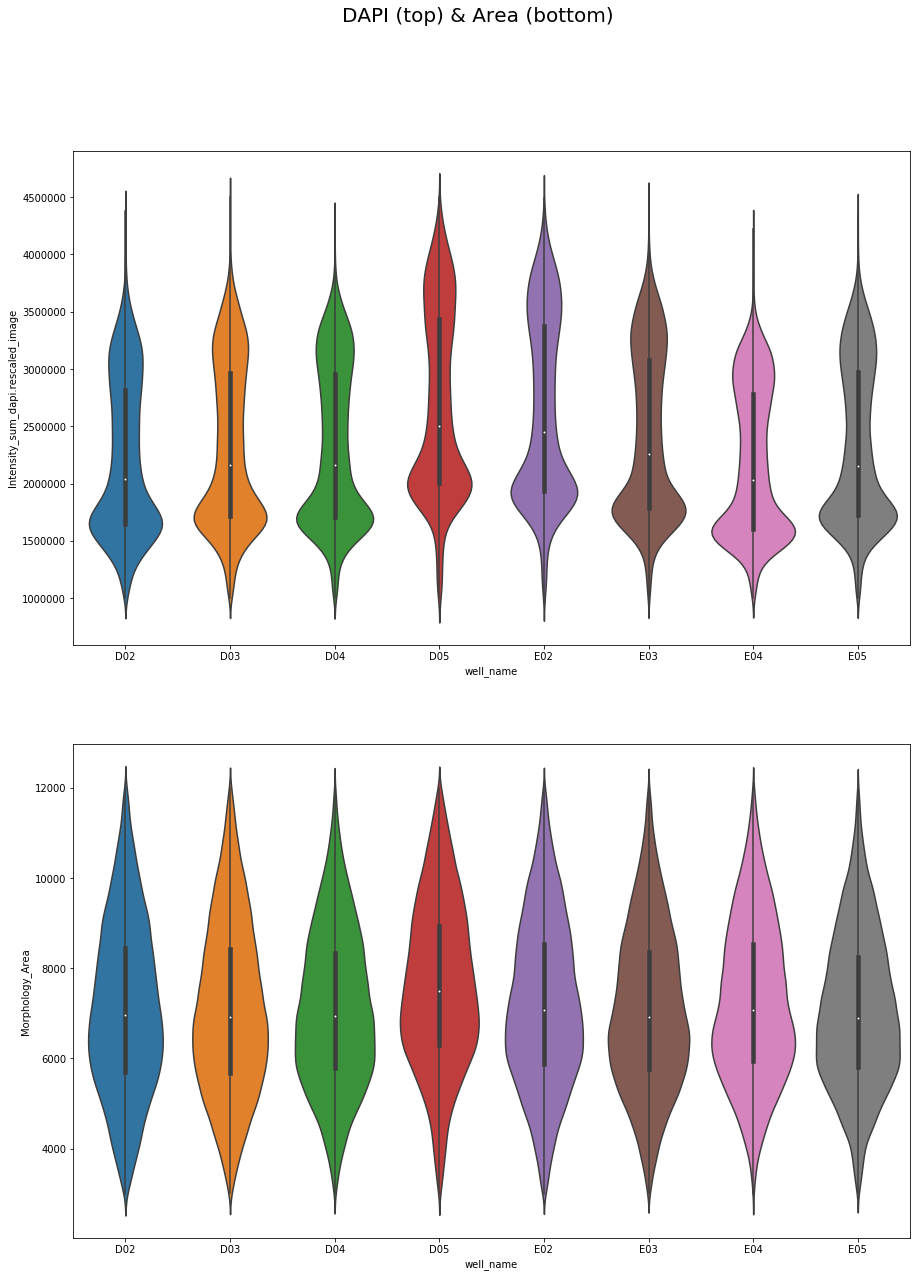

In [14]:
# Make some quality control plots
# DAPI violin plots
fig1, ax1 = plt.subplots(2, 1, figsize=(15, 20))
fig1.suptitle('DAPI (top) & Area (bottom)', fontsize = 20)
sns.violinplot(x = 'well_name', y = sum_intensity_dapi, data = results_cleaned, ax=ax1[0])
sns.violinplot(x = 'well_name', y = 'Morphology_Area', data = results_cleaned, ax=ax1[1])

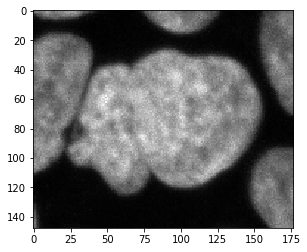

In [12]:
# Select cells to show with cellfi
dapi_outliers = results_cleaned.loc[results_cleaned[sum_intensity_dapi] > 4500000]
# print(dapi_outliers)
import tmclient
host="172.23.47.46"
port = 80
experimentName="20190723-StainingTest3"
username="joel"
password="123456"
mapobject="ExpandedNuclei-gfp"
client = tmclient.TmClient(host, port, username, password, experimentName)
cellfi = client.exhibit_mapobject(3870956, ['DAPI'], ooi=[mapobject], extra_margin=20) # , extra_margin=100
cellfi = list(cellfi)
for img in cellfi:
    plt.imshow(img, cmap='gray')

In [9]:
# print(dapi_outliers)
for img in cellfi:
    print(img.shape)

(148, 177)


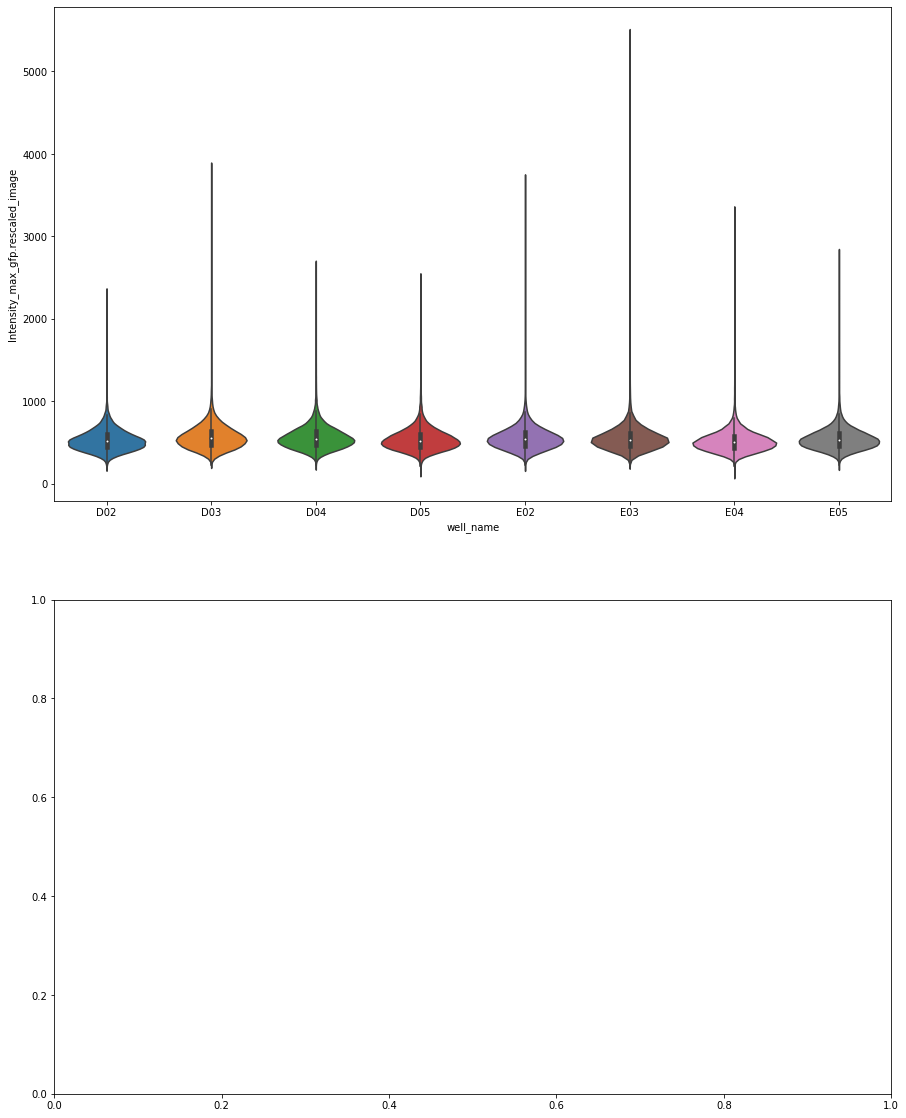

In [47]:
fig1, ax1 = plt.subplots(2, 1, figsize=(15, 20))
# fig1.suptitle('DAPI / 568 ratio', fontsize = 20)
lm = sns.violinplot(x = 'well_name', y = 'Intensity_max_gfp.rescaled_image', data = results_cleaned_noE06, ax=ax1[0])
# axes = lm.axes
# axes.set_ylim(0,10)
# lm2 =sns.violinplot(x = 'well_name', y = 'Intensity_mean_568.rescaled_image', data = results_cleaned, ax=ax1[1])
# axes = lm2.axes
# axes.set_ylim(0,200)
# well_name = 'B03'
# curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]
# g = sns.jointplot(x = 'Intensity_max_dapi.rescaled_image', y = 'DAPI/568_sumIntensity', data = curr_well, s=5) #, kind ='kde'

# print(curr_well.loc[curr_well['DAPI/568_sumIntensity'] > 80])


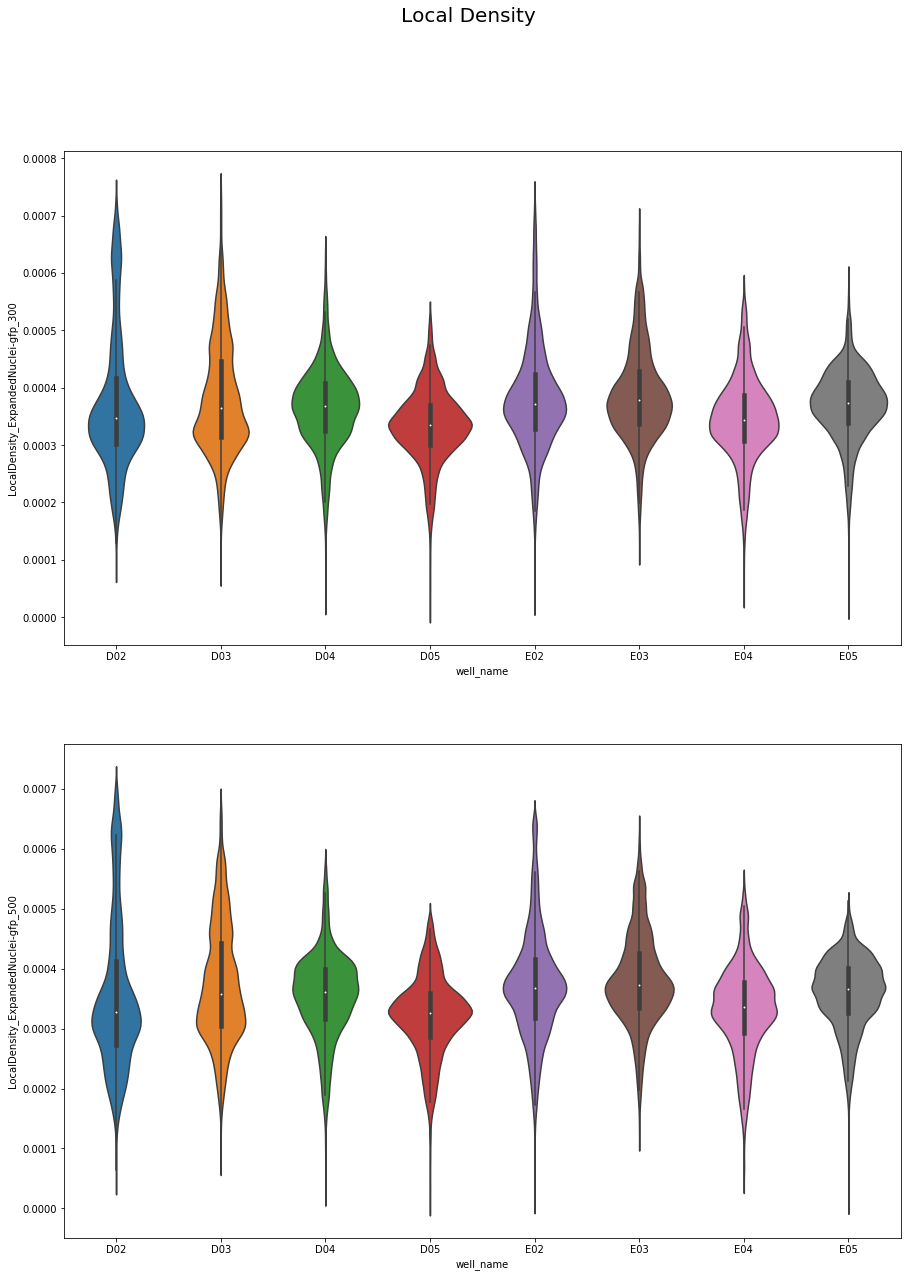

In [42]:
# Plot local density measurements
fig1, ax1 = plt.subplots(2, 1, figsize=(15, 20))
fig1.suptitle('Local Density', fontsize = 20)
# sns.violinplot(x = 'well_name', y = 'LocalDensity_Nuclei_100', data = results_cleaned, ax=ax1[0])
sns.violinplot(x = 'well_name', y = 'LocalDensity_ExpandedNuclei-gfp_300', data = results_cleaned, ax=ax1[0])
sns.violinplot(x = 'well_name', y = 'LocalDensity_ExpandedNuclei-gfp_500', data = results_cleaned, ax=ax1[1])

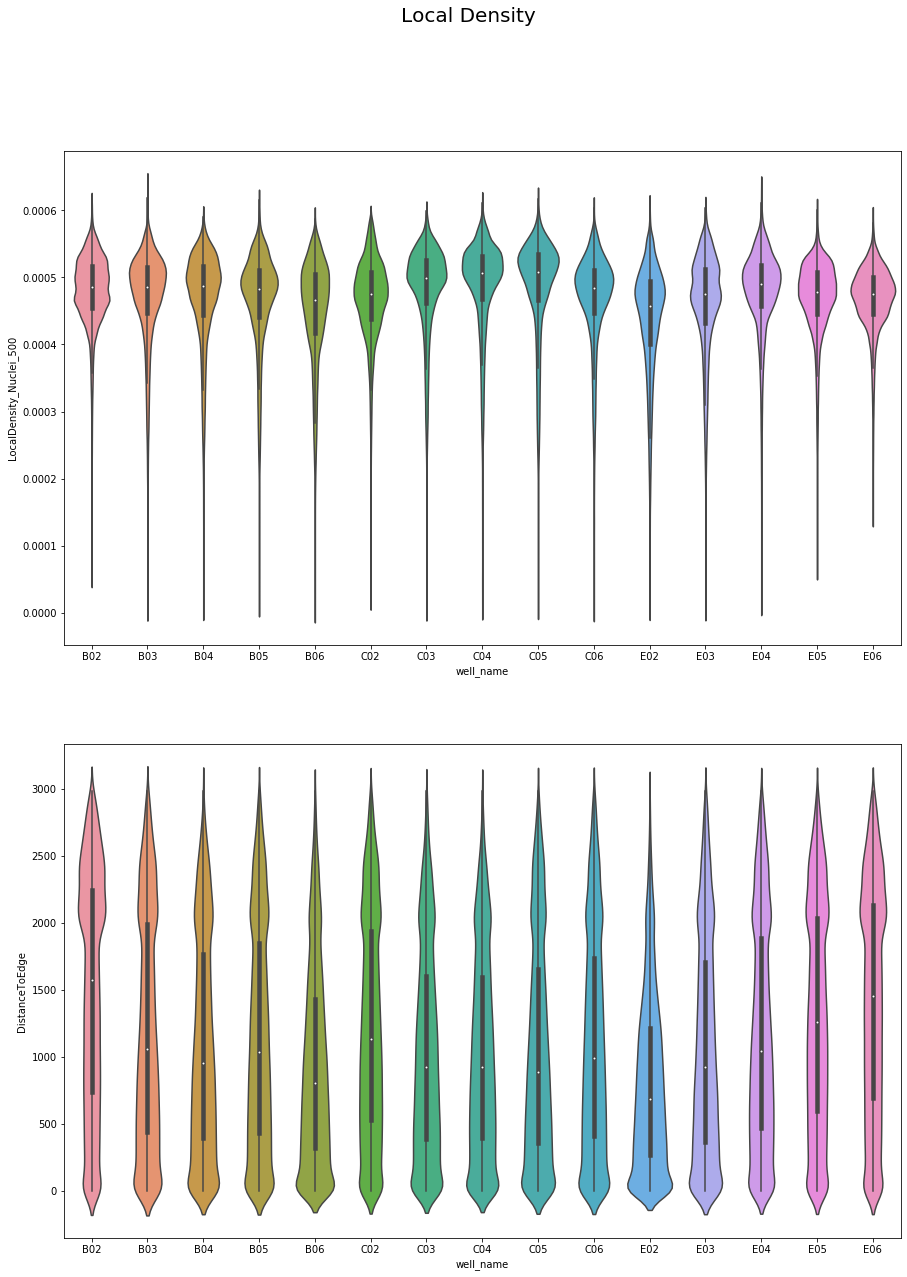

In [17]:
# Plot local density measurements
fig1, ax1 = plt.subplots(2, 1, figsize=(15, 20))
fig1.suptitle('Local Density', fontsize = 20)
sns.violinplot(x = 'well_name', y = 'LocalDensity_Nuclei_500', data = results_cleaned, ax=ax1[0])
sns.violinplot(x = 'well_name', y = 'DistanceToEdge', data = results_cleaned, ax=ax1[1])

/Users/Joel/.virtualenvs/jupyter/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


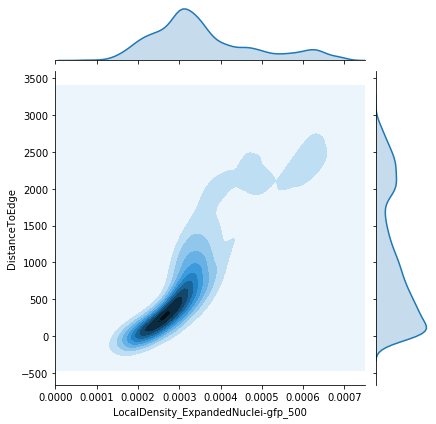

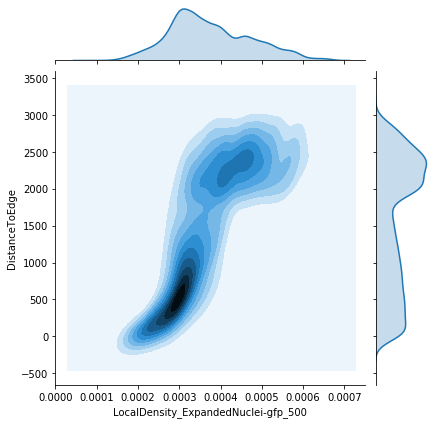

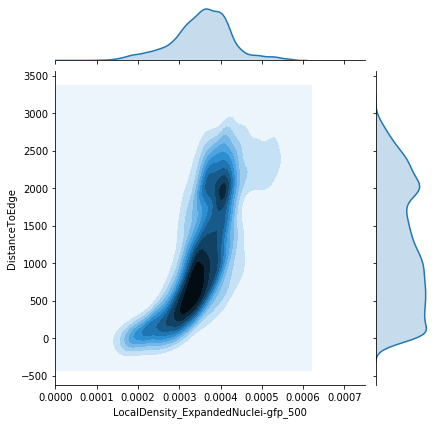

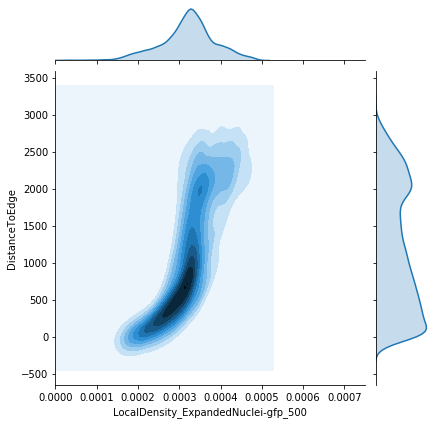

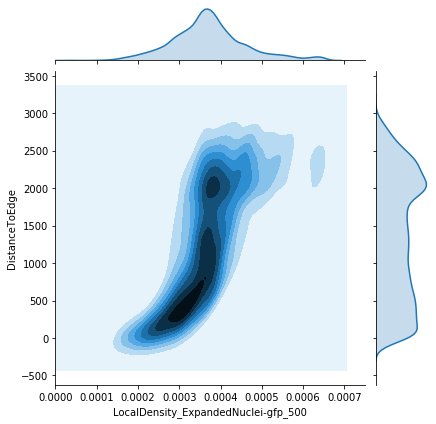

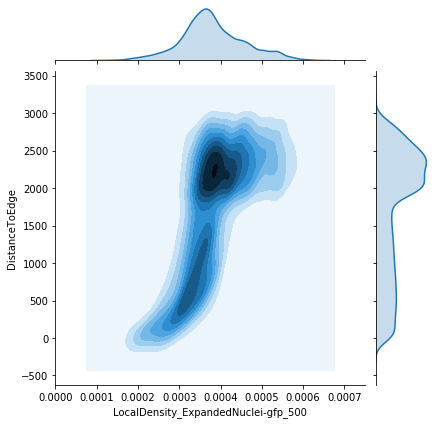

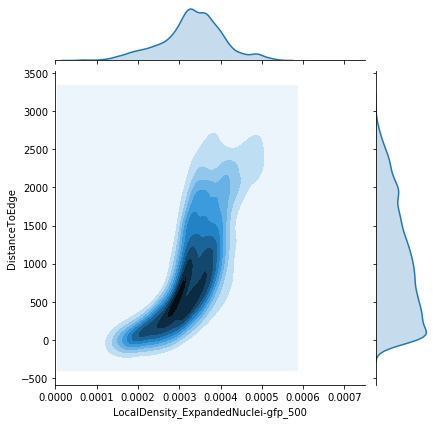

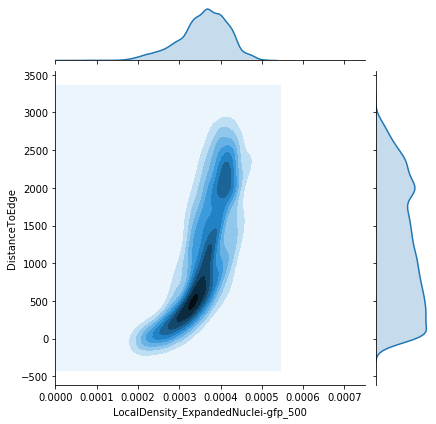

In [44]:
for well_name in wells:
    curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]
    g = sns.jointplot(x = 'LocalDensity_ExpandedNuclei-gfp_500', y = 'DistanceToEdge', data = curr_well, s=5, xlim=(0, 0.00075), kind ='kde')
    g.savefig('20190729-StainingTest3_' + well_name + '_DensityVsEdge.png')

/Users/Joel/.virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Joel/.virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Joel/.virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

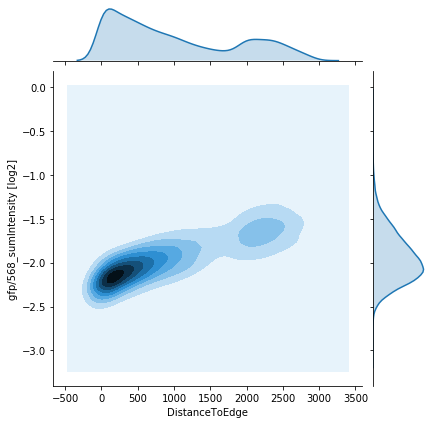

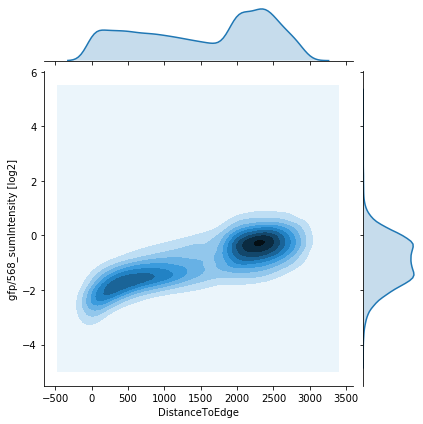

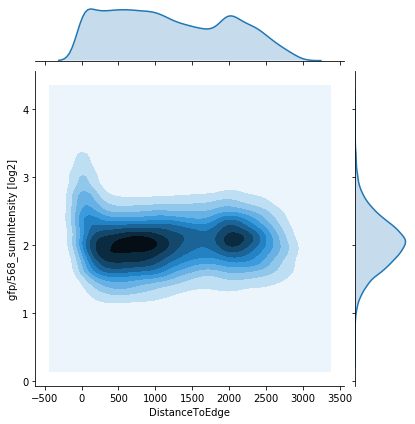

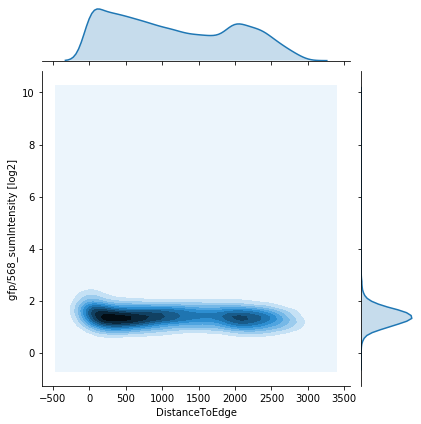

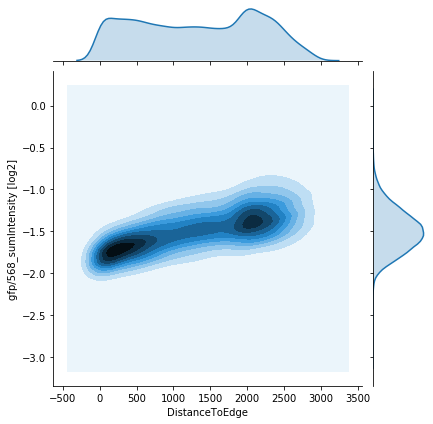

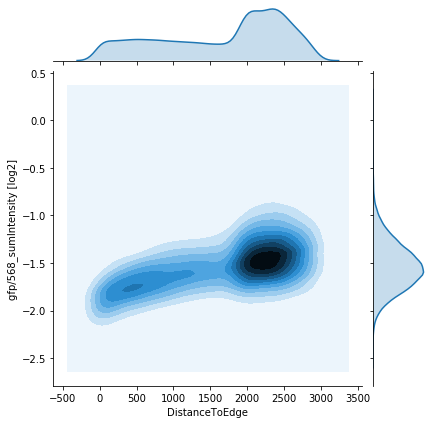

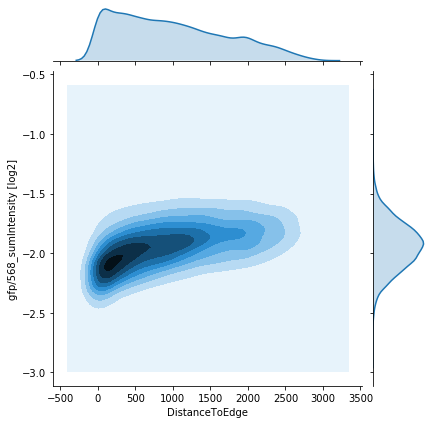

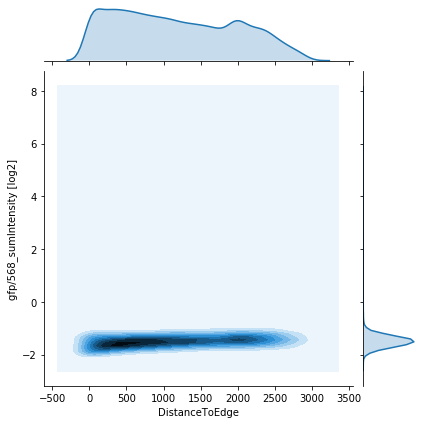

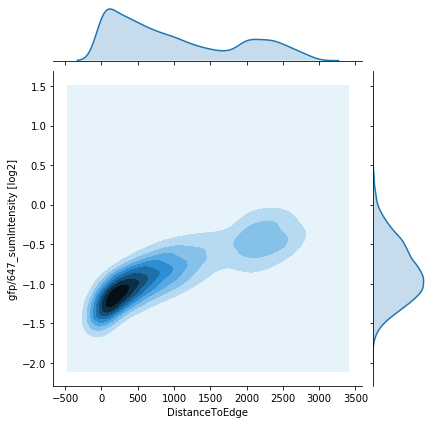

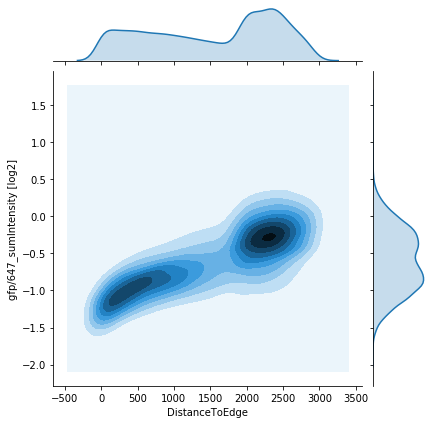

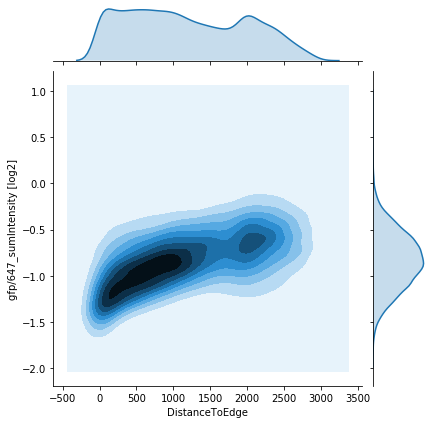

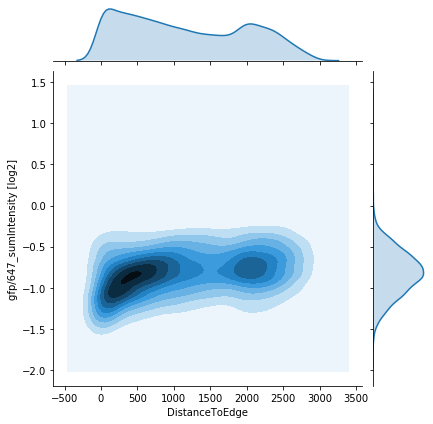

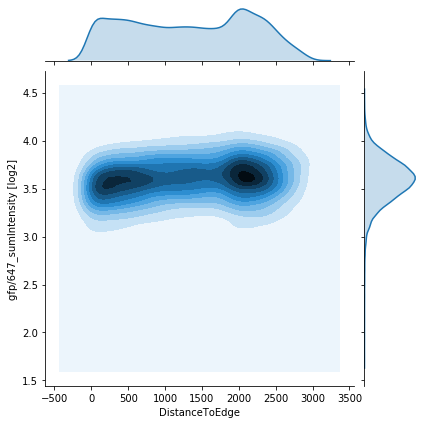

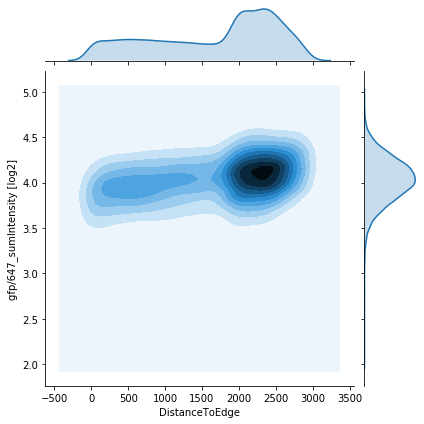

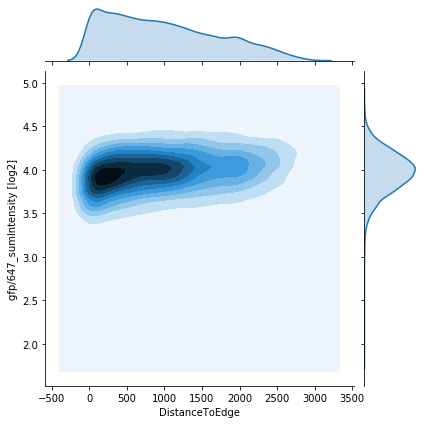

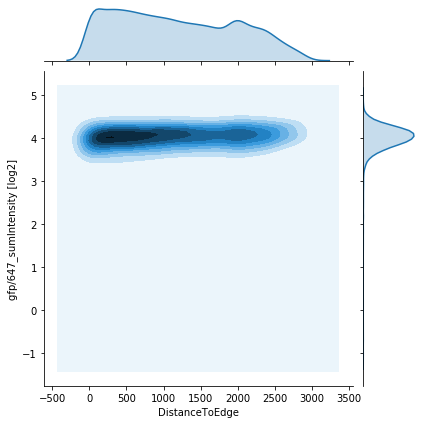

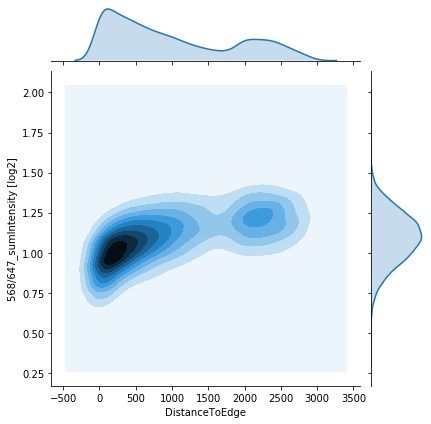

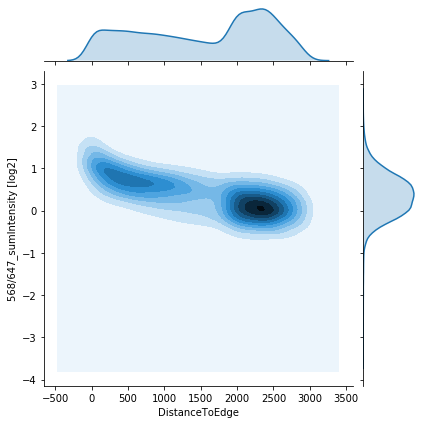

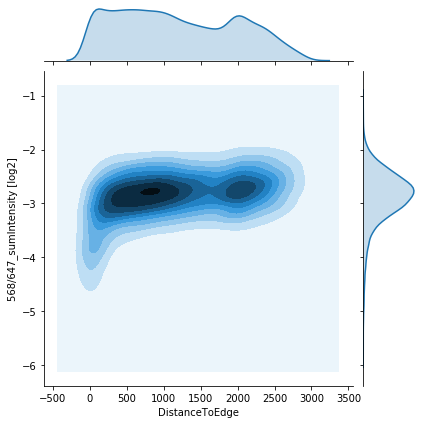

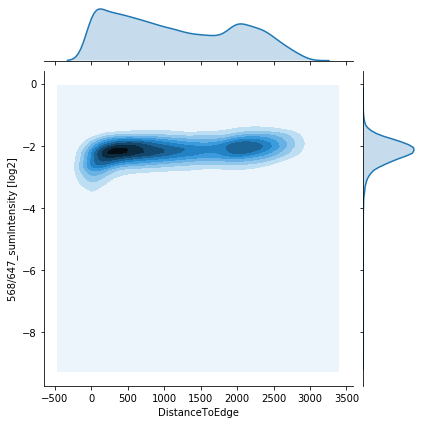

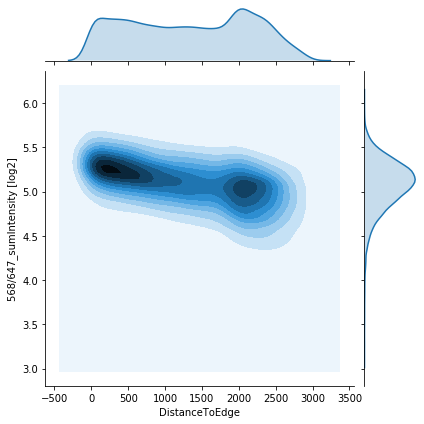

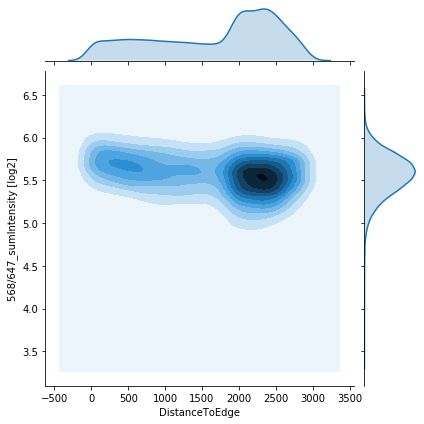

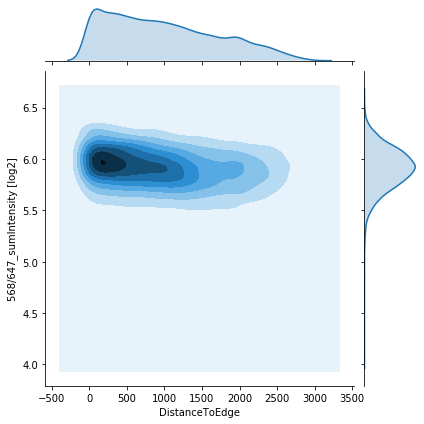

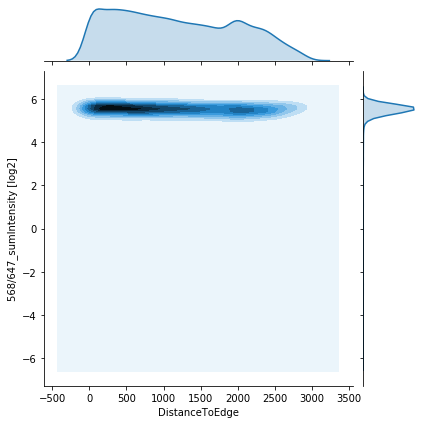

In [6]:
results_cleaned['gfp/568_sumIntensity [log2]'] = np.log2(results_cleaned['Intensity_sum_gfp.rescaled_image'] / results_cleaned['Intensity_sum_568.rescaled_image'])
results_cleaned['gfp/647_sumIntensity [log2]'] = np.log2(results_cleaned['Intensity_sum_gfp.rescaled_image'] / results_cleaned['Intensity_sum_647.rescaled_image'])
results_cleaned['568/647_sumIntensity [log2]'] = np.log2(results_cleaned['Intensity_sum_568.rescaled_image'] / results_cleaned['Intensity_sum_647.rescaled_image'])

for well_name in wells:
    curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]
    g = sns.jointplot(x = 'DistanceToEdge', y = 'gfp/568_sumIntensity [log2]', data = curr_well, s=5, kind ='kde')
    g.savefig('20190729-StainingTest3_gfp-568_sumIntensity_' + well_name + '.png')
for well_name in wells:
    curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]
    g = sns.jointplot(x = 'DistanceToEdge', y = 'gfp/647_sumIntensity [log2]', data = curr_well, s=5, kind ='kde')
    g.savefig('20190729-StainingTest3_gfp-647_sumIntensity' + well_name + '.png')

for well_name in wells:
    curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]
    g = sns.jointplot(x = 'DistanceToEdge', y = '568/647_sumIntensity [log2]', data = curr_well, s=5, kind ='kde')
    g.savefig('20190729-StainingTest3_568-647_sumIntensity' + well_name + '.png')

# results_cleaned['DAPI/647_sumIntensity'] = results_cleaned[sum_intensity_dapi] / results_cleaned['Intensity_sum_647.rescaled_image']
# wells_tmp = ['E02', 'E04']
# for well_name in wells_tmp:
#     curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]
#     g = sns.jointplot(x = 'DistanceToEdge', y = 'DAPI/647_sumIntensity', data = curr_well, kind ='kde')
#     g.savefig('EdgeVs647_' + well_name + '.png')
    

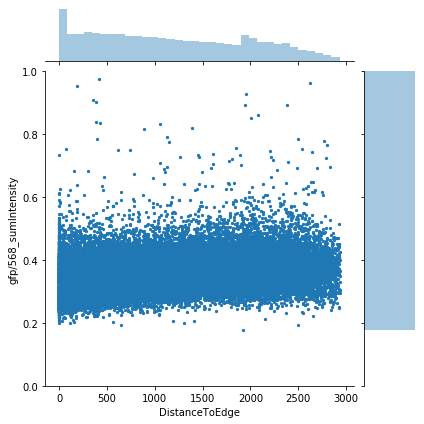

In [50]:
well_name = 'E05'
curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]
g = sns.jointplot(x = 'DistanceToEdge', y = 'gfp/568_sumIntensity', data = curr_well, s=5, ylim=(0, 1)) #, kind ='kde'
g.savefig('20190729-StainingTest3_gfp-568_sumIntensity_' + well_name + '.png')

/Users/Joel/.virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


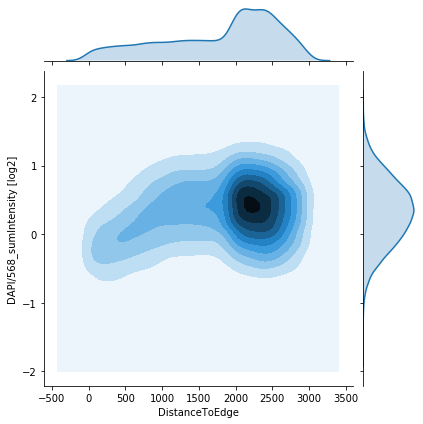

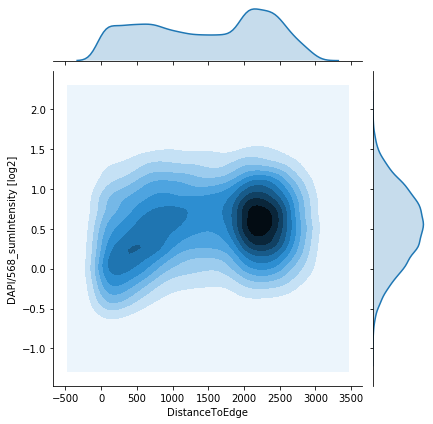

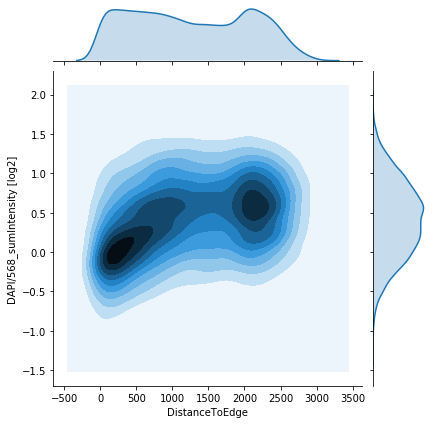

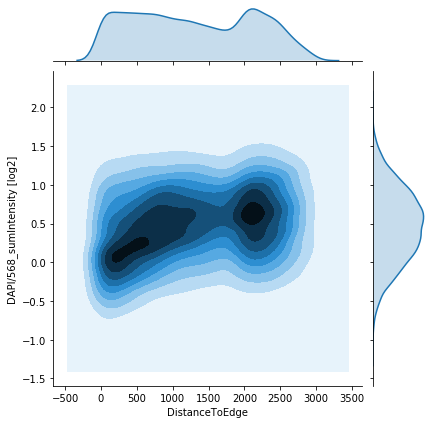

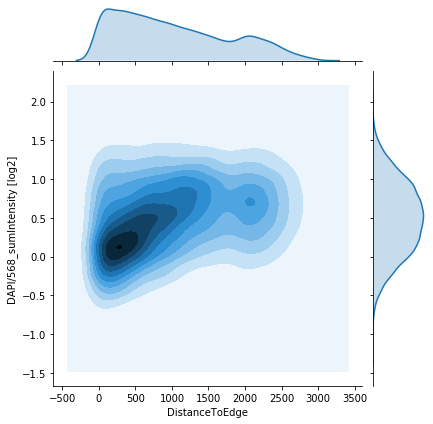

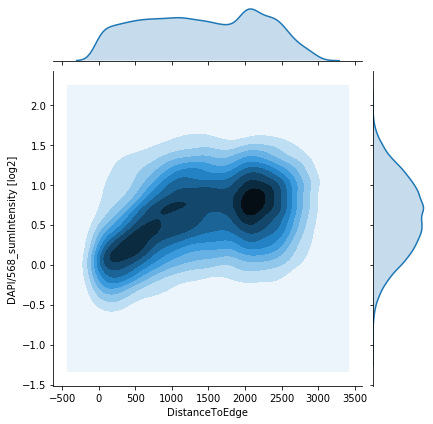

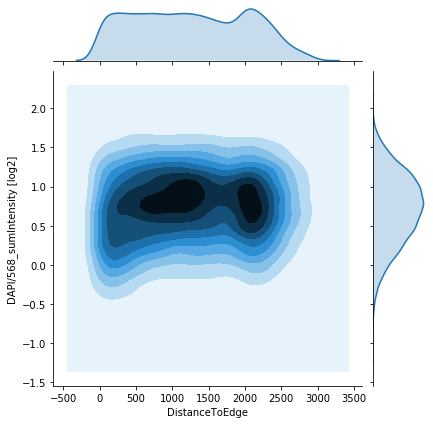

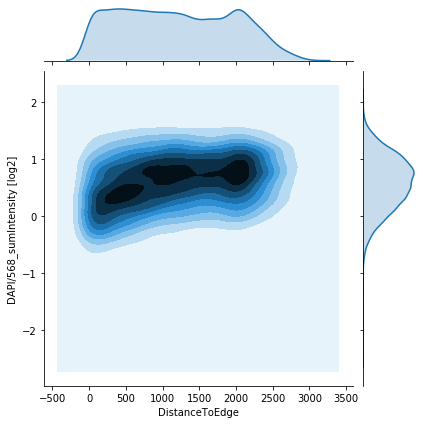

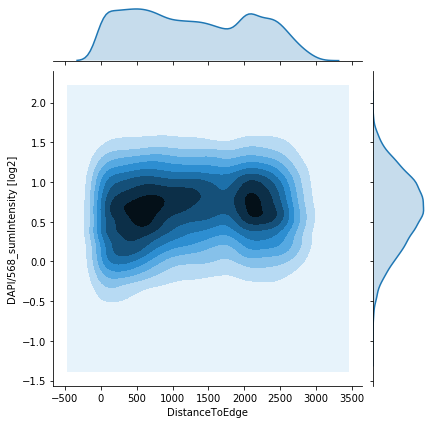

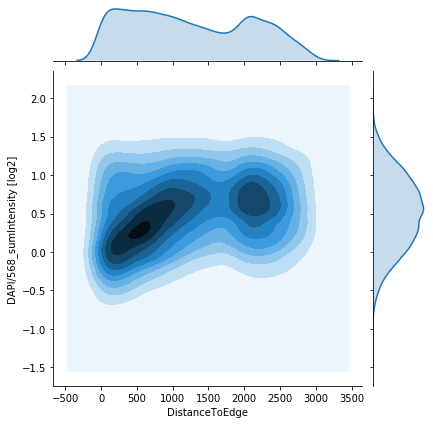

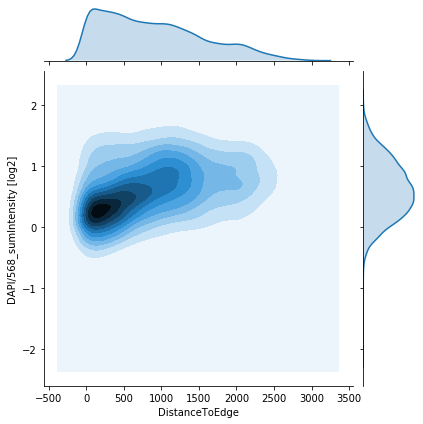

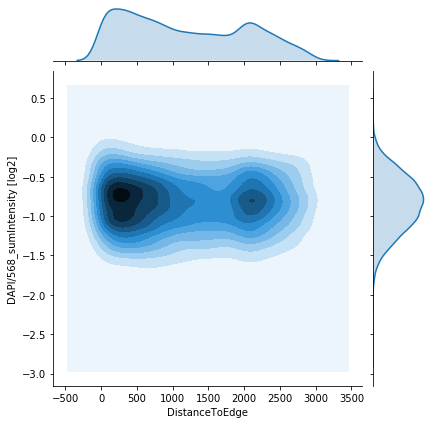

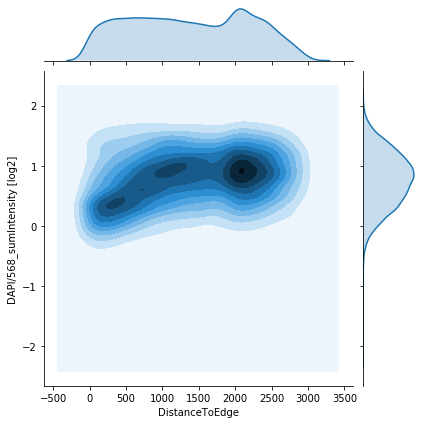

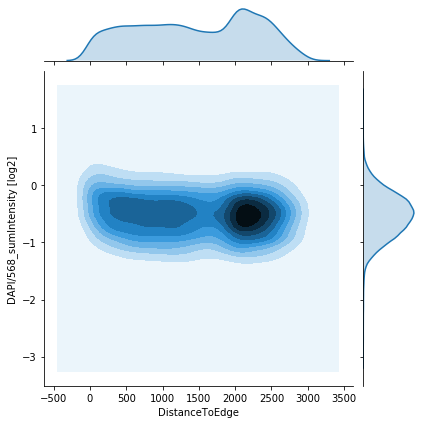

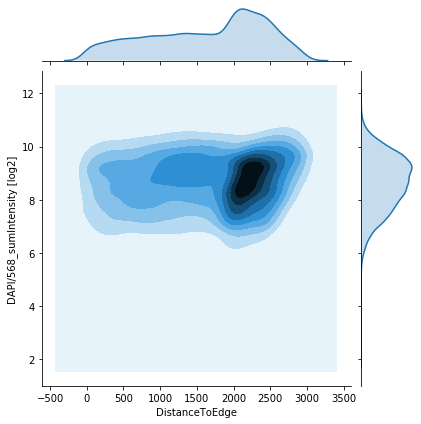

In [24]:
# results_cleaned['DAPI/568_sumIntensity [log2]'] = np.log2(results_cleaned[sum_intensity_dapi] / results_cleaned[sum_Intensity_568])

for well_name in wells:
    curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]
    g = sns.jointplot(x = 'DistanceToEdge', y = 'DAPI/568_sumIntensity [log2]', data = curr_well, s=5, kind ='kde')
    g.savefig(well_name + '_EdgeVsDapiToNanog.png')
    
# for well_name in wells:
#     curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]
#     g = sns.jointplot(x = 'DistanceToEdge', y = 'Intensity_mean_dapi.rescaled_image', data = curr_well, s=5, kind ='kde')
#     g.savefig('EdgeVsDapi_' + well_name + '.png')

# for well_name in wells:
#     curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]
#     g = sns.jointplot(x = 'DistanceToEdge', y = 'Intensity_mean_568.rescaled_image', data = curr_well, s=5, kind ='kde')
#     g.savefig('EdgeVs568_' + well_name + '.png')

# results_cleaned['DAPI/647_sumIntensity'] = results_cleaned[sum_intensity_dapi] / results_cleaned['Intensity_sum_647.rescaled_image']
# wells_tmp = ['E02', 'E04']
# for well_name in wells_tmp:
#     curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]
#     g = sns.jointplot(x = 'DistanceToEdge', y = 'DAPI/647_sumIntensity', data = curr_well, kind ='kde')
#     g.savefig('EdgeVs647_' + well_name + '.png')

0.1366030800696677
0.20921605042739236
0.10388311647366699
0.2601928218150626
0.20380889862385385
0.20163097747858627
0.21433978869323864
0.23115329799401324
0.14935220022601003
0.1313155693243598
0.14012979859218827
0.16847847259633583
0.16205954135313955
0.15882245340014342
0.16292429799343555
0.18295784001295404


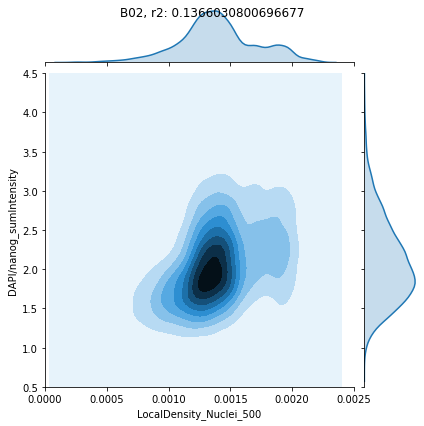

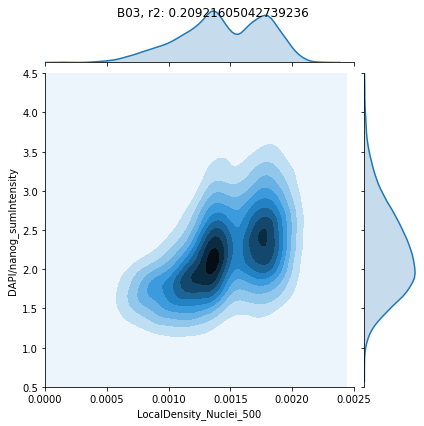

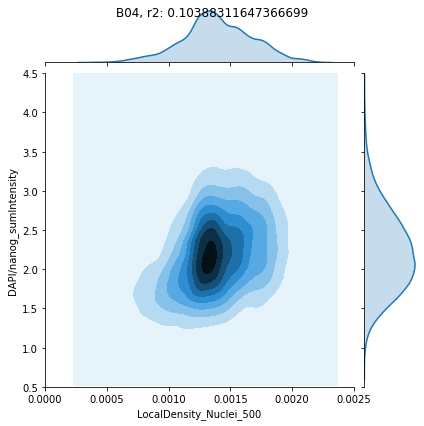

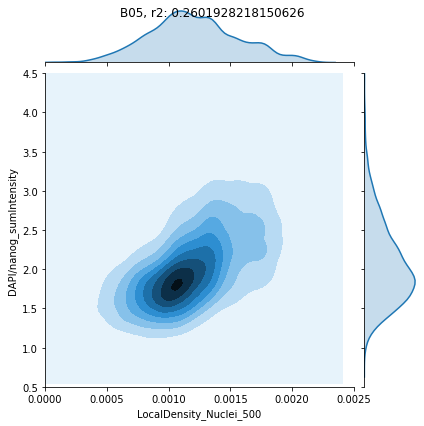

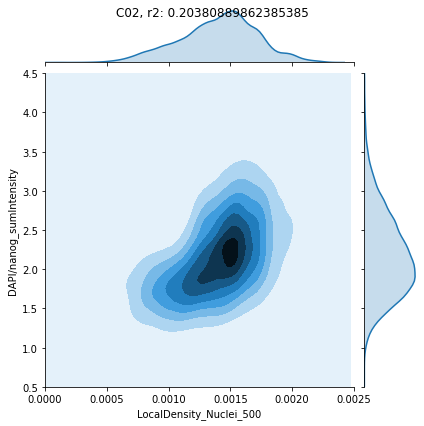

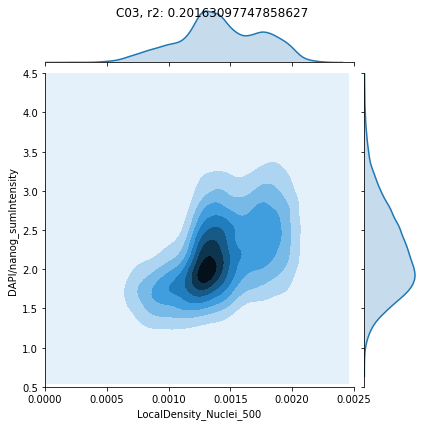

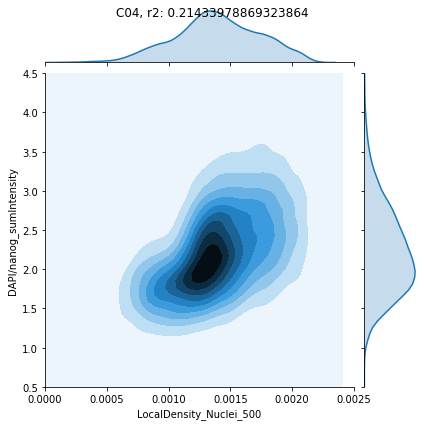

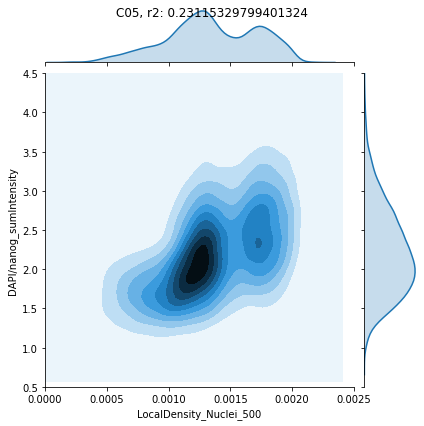

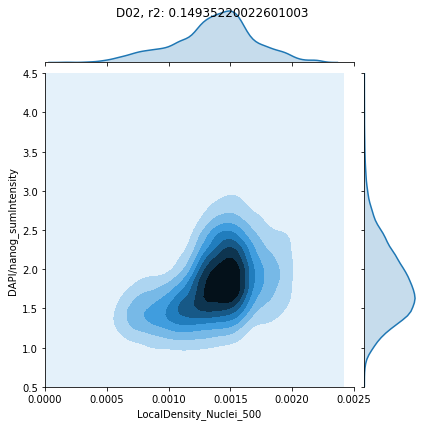

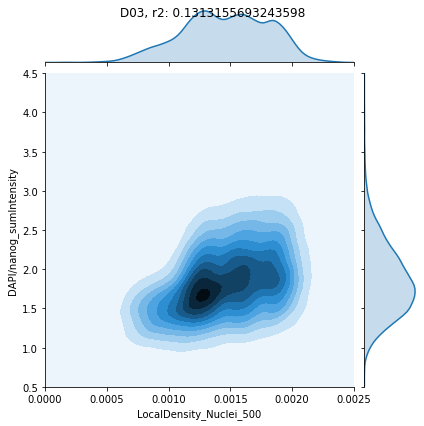

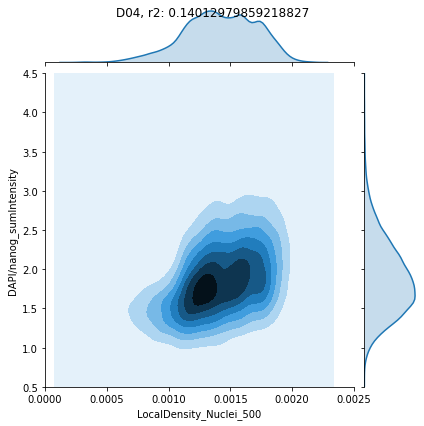

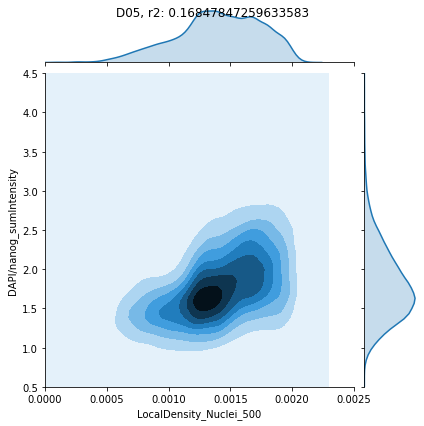

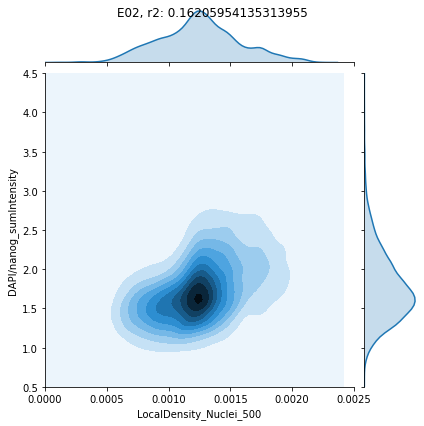

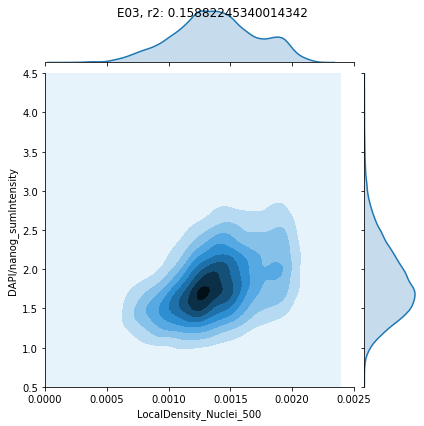

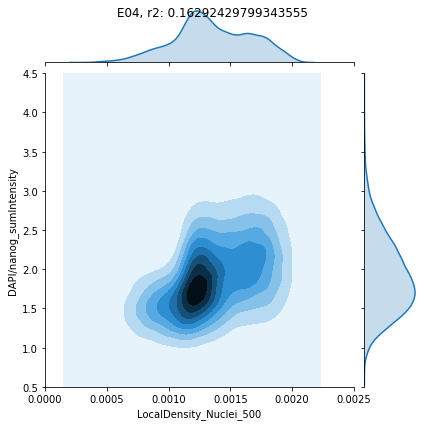

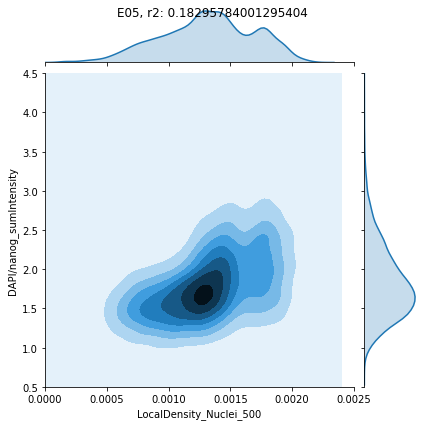

In [122]:
# Plot relationship DAPI/nanog (vs. density)
import scipy
# well_name = 'B04'
for well_name in wells:
    curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]

    # fig1, ax1 = plt.subplots(2, 1, figsize=(15, 20))
    # fig1.suptitle('DAPI/nanog Intensity Ratio', fontsize = 20)
    # sns.violinplot(x = 'well_name', y = 'DAPI/nanog_sumIntensity', data = results_cleaned, ax=ax1[0])

    # g = sns.jointplot(x = 'LocalDensity_Nuclei_500', y = 'DAPI/nanog_sumIntensity', data = curr_well, s=5, xlim=(0, 0.0025), ylim = (0.5, 4.5)) # 
    g = sns.jointplot(x = 'LocalDensity_Nuclei_500', y = 'DAPI/nanog_sumIntensity', data = curr_well, s=5, xlim=(0, 0.0025), ylim = (0.5, 4.5), kind ='kde')

    # Calculate correlation between Density & DAPI/nanog
    density = np.array(curr_well['LocalDensity_Nuclei_500'])
    intensity_ratio = np.array(curr_well['DAPI/nanog_sumIntensity'])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(density, intensity_ratio)
    print(r_value*r_value)


    g.fig.suptitle(well_name + ', r2: ' + str(r_value*r_value))

    g.savefig(well_name + '_DensityVsStainingBias.png')


In [116]:
# Calculate correlation between Density & DAPI/nanog
import scipy
well_name = 'B02'
curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]

density = np.array(curr_well['LocalDensity_Nuclei_500'])
intensity_ratio = np.array(curr_well['DAPI/nanog_sumIntensity'])
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(density, intensity_ratio)
print(r_value*r_value)



0.1366030800696677


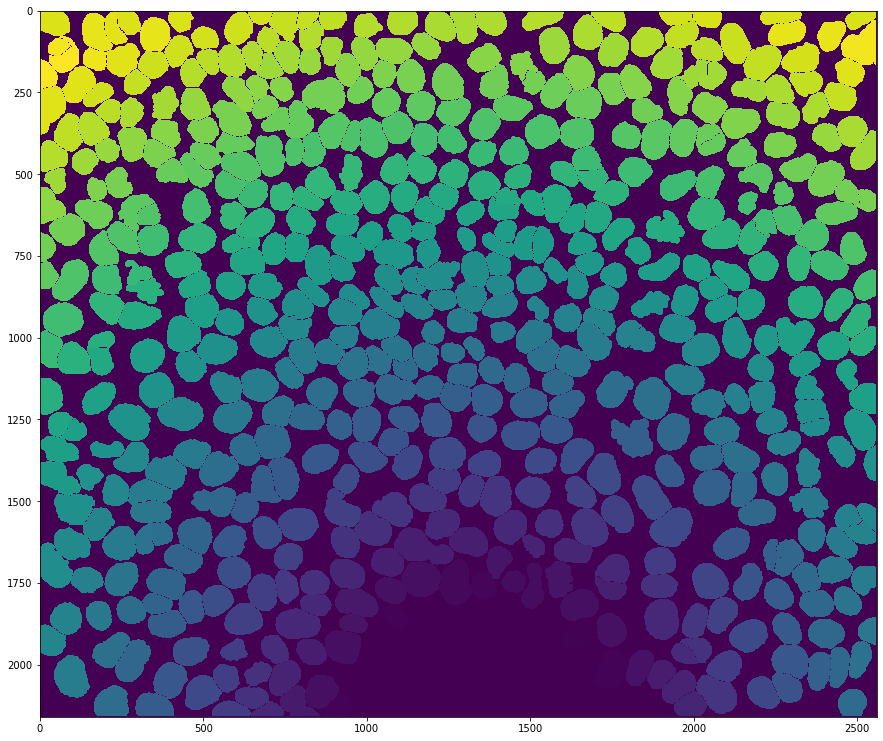

In [33]:
# Local density mapped back on the images
img_width = 2560
img_height = 2160

density_img = np.zeros((img_width, img_height))

# Define site of interest
well_name = 'D03'
well_pos_y = 4
well_pos_x = 4
current_site_bool = (results['well_name'] == well_name) & (results['well_pos_y'] == well_pos_y)  & (results['well_pos_x'] == well_pos_x)

current_site = results.loc[current_site_bool]

# Get the segmentation mask from TissueMaps
import tmclient
host="172.23.47.46"
port = 80
experimentName="20190723-StainingTest3"
username="joel"
password="123456"
mapobject="ExpandedNuclei-gfp"
client = tmclient.TmClient(host, port, username, password, experimentName)

plateDownload = client.get_plates()
plate_name = plateDownload[0]['name']

segmentation_image = client.download_segmentation_image(mapobject, plate_name, well_name, well_pos_y, well_pos_x)
# plt.figure(figsize=(15,20))
# imgplot = plt.imshow(segmentation_image)

img_width = 2560
img_height = 2160

density_img = np.zeros((img_height, img_width))

# Loop through all labels
labels = current_site['label']

for label in labels:
    current_cell = current_site.loc[current_site['label'] == label]
    density_img[segmentation_image == label] = current_cell['DistanceToEdge']

plt.figure(figsize=(15,20))
imgplot = plt.imshow(density_img)


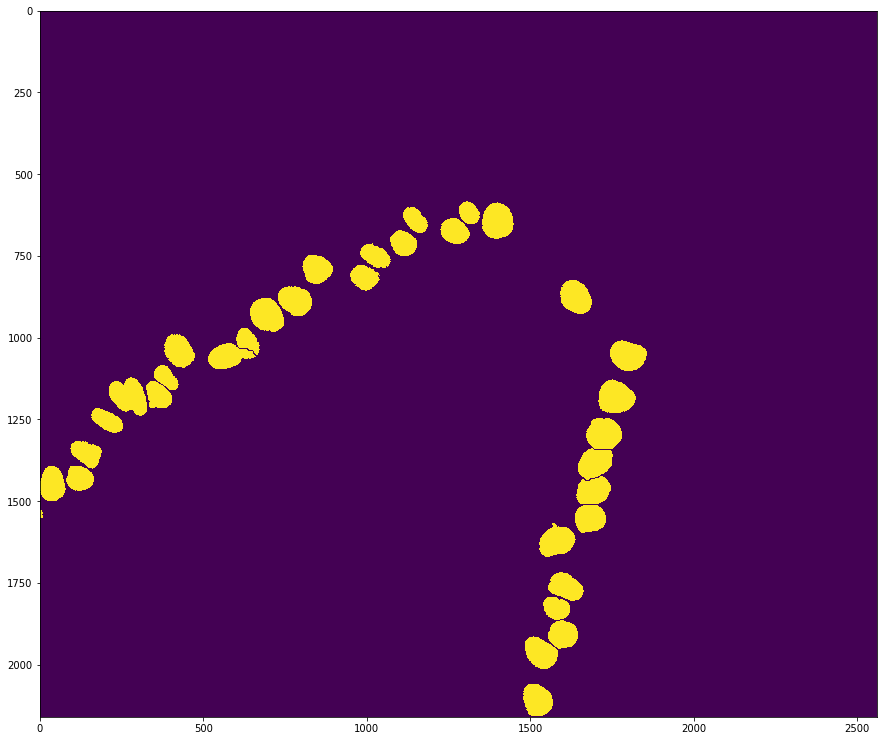

In [9]:
img_width = 2560
img_height = 2160

density_img = np.zeros((img_height, img_width))

# Loop through all labels
labels = current_site['label']

for label in labels:
    current_cell = current_site.loc[current_site['label'] == label]
    density_img[segmentation_image == label] = current_cell['isEdge']

plt.figure(figsize=(15,20))
imgplot = plt.imshow(density_img)


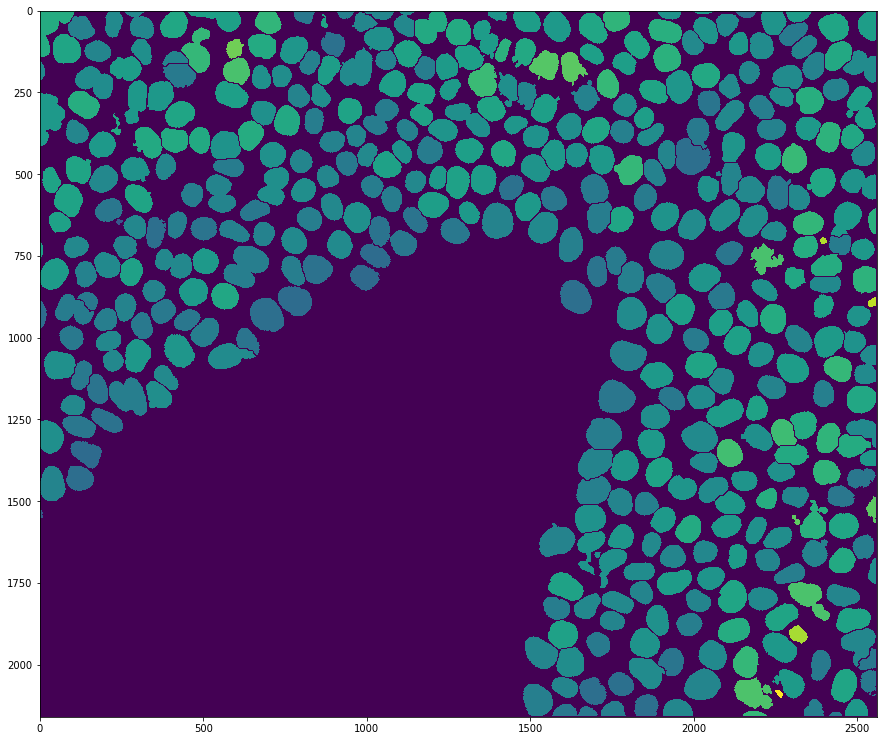

In [12]:
img_width = 2560
img_height = 2160

density_img = np.zeros((img_height, img_width))

# Loop through all labels
labels = current_site['label']

for label in labels:
    current_cell = current_site.loc[current_site['label'] == label]
    density_img[segmentation_image == label] = current_cell['Intensity_mean_dapi.rescaled_image']

plt.figure(figsize=(15,20))
imgplot = plt.imshow(density_img)

In [31]:
# Calculate average spot counts per well 
# print(results_cleaned.groupby('well_name')['mRNA_Count'].median())
# print(results_cleaned.groupby('well_name')['mRNA_Pbody_Count'].mean())

In [27]:
# Look at percentage of transcripts in P-bodies
# results_cleaned = results_cleaned.assign(percentage_pbody_2 = 0)
# cells_with_pbodies = results_cleaned['mRNA_Count'] >= 1
# results_cleaned.loc[cells_with_pbodies,'percentage_pbody'] = results_cleaned['mRNA_Pbody_Count'][cells_with_pbodies]/results_cleaned['mRNA_Count'][cells_with_pbodies]
# print(results_cleaned['percentage_pbody'].describe())


In [28]:
# fig1, ax1 = plt.subplots(2, 1, figsize=(15, 20))
# fig1.suptitle('mRNA Spot counts', fontsize = 20)
# g = sns.violinplot(x = 'well_name', y = 'percentage_pbody', data = results_cleaned.loc[hela_C_row], ax=ax1[0])
# g.set(xticklabels=['HPRT', 'Lamp1', 'CCND1', 'HIF1A', 'dapB', 'no probe', 'SPEN', 'no probe'])
# h = sns.violinplot(x = 'well_name', y = 'percentage_pbody', data = results_cleaned.loc[hek_E_row], ax=ax1[1])
# h.set(xticklabels=['HPRT', 'Lamp1', 'CCND1', 'HIF1A', 'dapB', 'no probe', 'SPEN', 'no probe'])


In [29]:
# Plot percentage P-bodies vs cellular features (area, #Pbodies total, DNA content, protein content)
# fig1, ax1 = plt.subplots(2, 2, figsize=(15, 15))
# fig1.suptitle('Percentage Pbodies vs. cell Features', fontsize = 20)
# SPEN_hek = results_cleaned['well_name'] == 'E09'
# sns.jointplot(x = 'Nuclei_Intensity_sum_DAPI', y = 'percentage_pbody', data = results_cleaned.loc[SPEN_hek,], s=10)
# sns.jointplot(x = 'Pbodies_Count', y = 'percentage_pbody', data = results_cleaned.loc[SPEN_hek,],s=10)
# sns.jointplot(x = 'Morphology_Area', y = 'percentage_pbody', data = results_cleaned.loc[SPEN_hek,],s=10)
# sns.jointplot(x = 'Intensity_mean_Succs', y = 'percentage_pbody', data = results_cleaned.loc[SPEN_hek,],s=10)

# CCND1_hela = results_cleaned['well_name'] == 'C05'
# g = sns.jointplot(x = 'Nuclei_Intensity_sum_DAPI', y = 'percentage_pbody', data = results_cleaned.loc[CCND1_hela,], s=10)
# sns.jointplot(x = 'Pbodies_Count', y = 'percentage_pbody', data = results_cleaned.loc[CCND1_hela,],s=10)
# sns.jointplot(x = 'Morphology_Area', y = 'percentage_pbody', data = results_cleaned.loc[CCND1_hela,],s=10)
# sns.jointplot(x = 'Intensity_mean_Succs', y = 'percentage_pbody', data = results_cleaned.loc[CCND1_hela,],s=10)

# lamp1_hela = results_cleaned['well_name'] == 'C04'
# g = sns.jointplot(x = 'Nuclei_Intensity_sum_DAPI', y = 'percentage_pbody', data = results_cleaned.loc[lamp1_hela,], s=10)
# sns.jointplot(x = 'Pbodies_Count', y = 'percentage_pbody', data = results_cleaned.loc[lamp1_hela,],s=10)
# sns.jointplot(x = 'Morphology_Area', y = 'percentage_pbody', data = results_cleaned.loc[lamp1_hela,],s=10)
# sns.jointplot(x = 'Intensity_mean_Succs', y = 'percentage_pbody', data = results_cleaned.loc[lamp1_hela,],s=10)


In [20]:
# Save dataframe as csv
# results_cleaned.to_csv('20181203-bDNA-FISH8-results-cleaned_improved.csv')

Load data directly from TissueMaps for single wells

In [30]:
# import tmclient
# host="172.23.47.46"
# port = 80
# experimentName="20181203-bDNA-FISH-8"
# username="joel"
# password="123456"
# mapobject="Cells"
# client = tmclient.TmClient(host, port, username, password, experimentName)

# plateDownload = client.get_plates()
# plate_name = plateDownload[0]['name']

# wells = ['C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'E03', 'E08']
# for well in wells:
#     print(well)
#     site_y = 0
#     for site_x in range(1,3):
#         feature_values = client.download_feature_values(mapobject, plate_name, well, site_y, site_x)
#         print(feature_values['mRNA_T1_Count_bDNA-FISH'].mean())
# #         print(feature_values['mRNA_Pbody_T1_Count'].mean())

# wells = ['C09', 'C10']
# for well in wells:
#     print(well)
#     site_y = 0
#     for site_x in range(1,3):
#         feature_values = client.download_feature_values(mapobject, plate_name, well, site_y, site_x)
#         print(feature_values['mRNA_T4_Count_bDNA-FISH'].mean()) 